# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.debugger import set_trace
import json
from matplotlib import colors

# Load data

In [3]:
PATH = "data/rivka-necklace-rep-data/psynet/data/"
nodes = pd.read_csv(PATH + "node.csv", low_memory=False)
networks = pd.read_csv(PATH + "network.csv", low_memory=False)
info = pd.read_csv(PATH + "info.csv", low_memory=False)

# Preprocess data

In [4]:
# filter networks
network_data = networks
network_data = network_data[network_data["role"] == "experiment"]
network_data = network_data[network_data["failed"] == 'f']
network_data = network_data[network_data["trial_maker_id"] == 'graph_experiment']

experiment_net_id = list(network_data['id'].to_numpy())

# filter info
info_data = info
info_data = info_data[info["type"] == "graph_chain_trial"]
info_data = info_data[info_data["failed"] == "f"]
info_data = info_data[info_data["network_id"].isin(experiment_net_id)]
info_data = info_data[["id", "network_id", "origin_id", "answer", "definition"]]

# filter nodes
node_data = nodes
node_data = node_data[nodes["type"] == "graph_chain_node"]
node_data = node_data[node_data["failed"] == "f"]
node_data = node_data[node_data["network_id"].isin(experiment_net_id)]
node_data = node_data[["id", "network_id", "degree", "definition", "seed", "vertex_id", "dependent_vertex_ids"]]

Most common necklaces analysis

In [5]:
# Extracts the answer necklace
# answer (a) is given as a string formatted as "[i, [x, x, x, x, x, x, x, x, x]" where i is the choice of necklace in 'choice' round and the list is the necklace reproduced
# if the person tried to submit an invalid necklace first (containing '-1') there will be two lists
def extract_answer_necklace(a):
    a = a.strip('][').split(', ', 1)    # strip the outer brackets and split into choice/reproduce
    if '-1' in a[1]:                    # remove the invalid reproduced necklace if relevant
        a[1] = a[1].strip('[').split('], [')[1]
    a[1] = a[1].strip('][').split(', ') # remove the outer brackets of the necklace and split 
    a[1] = [int(x) for x in a[1]]       # turn circles into ints
    return a[1]

In [6]:
# Adds choice, parsed_definition, and reproduced_necklace columns
def extract_choice(a):
    a = a.strip('][').split(', ', 1)
    a = int(a[0])
    return a

def convert_json(d):
    return json.loads(d)

info_data["choice"] = info_data["answer"].apply(extract_choice)
info_data["parsed_definition"] = info_data["definition"].apply(convert_json)
info_data["reproduced_necklace"] = info_data["answer"].apply(extract_answer_necklace)

In [7]:
# Adds chosen_necklace column using above information
chosen_necklaces = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    curr_necklace = curr_row["parsed_definition"][curr_row["choice"]]["content"]
    chosen_necklaces.append(curr_necklace)
info_data["chosen_necklace"] = chosen_necklaces
# info_data["chosen_necklace"] = info_data.apply(lambda x: extract_chosen_necklace( info_data.parsed_definition, info_data.choice), axis=1)

In [8]:
def convert_to_pattern(necklace):
    color_to_code = {}
    pattern = []
    color_codes = ["a", "b", "c"]
    color_index = 0

    if isinstance(necklace, str):
        necklace = necklace.strip('][').split(', ')

    for circle_color in necklace:
        if circle_color not in color_to_code:
            color_to_code[circle_color] = color_codes[color_index]
            color_index += 1
        pattern.append(color_to_code[circle_color])
    
    return pattern

In [9]:
info_data["chosen_necklace_pattern"] = info_data["chosen_necklace"].apply(convert_to_pattern)
info_data["reproduced_necklace_pattern"] = info_data["reproduced_necklace"].apply(convert_to_pattern)

In [10]:
degrees = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    node_id = curr_row["origin_id"]
    node_row = node_data[node_data["id"] == node_id]
    degrees.append(node_row.iloc[0]["degree"])
info_data["degree"] = degrees
info_data = info_data.sort_values("degree")

In [11]:
# degree_freqs = {} # alternative for dict
degree_freqs = []
for i in range(1, 22):
    j = float(i)
    necklace_freqs = {}
    info_of_degree = info_data[info_data["degree"] == j]
    for necklace in info_of_degree["reproduced_necklace_pattern"]:
        necklace = str(necklace)
        if necklace in necklace_freqs:
            necklace_freqs[necklace] += 1
        else:
            necklace_freqs[necklace] = 1
    sorted_necklaces = sorted( ((v, k) for k, v in necklace_freqs.items()), reverse=True)
    degree_freqs.append(sorted_necklaces)
    # degree_freqs[j] = (sorted_necklaces) # alternative for dict

In [12]:
pd.DataFrame(degree_freqs).to_csv("social-patterns-by-degree.csv")

In [13]:
# fraction of people agreeing
frac_degrees = []
for degree_list in degree_freqs:
    total_num = sum([l[0] for l in degree_list])
    top_three = []
    for i in range(3): # top three necklaces
        if i < len(degree_list):
            necklace = degree_list[i][1]
            frac = round(degree_list[i][0]/total_num, 2)
            top_three.append((frac, necklace))
        else:
            top_three.append((None, None))
    frac_degrees.append(top_three)

In [14]:
pd.DataFrame(frac_degrees).to_csv("social-frac-agree-top-three.csv")

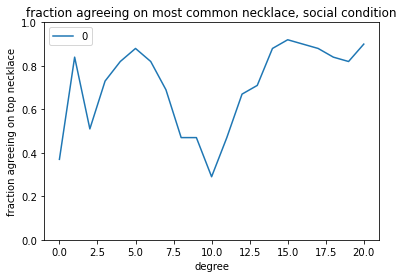

In [19]:
# fraction of people agreeing on top necklace
top_fracs = [top_three[0][0] for top_three in frac_degrees]
pd.DataFrame(top_fracs).plot(xlabel="degree", ylabel="fraction agreeing on top necklace", title="fraction agreeing on most common necklace, social condition", ylim=(0, 1))
pd.DataFrame(top_fracs).to_csv("social_top_frac.csv")

In [20]:
sum(top_fracs)/len(top_fracs)

0.7085714285714286

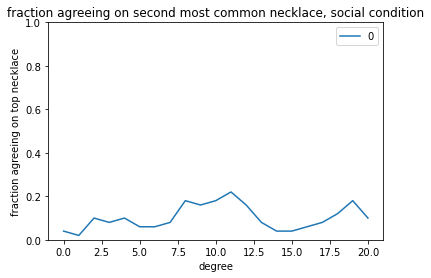

In [21]:
# fraction of people agreeing on secondary top necklace
second_fracs = [top_three[1][0] for top_three in frac_degrees]
pd.DataFrame(second_fracs).plot(xlabel="degree", ylabel="fraction agreeing on top necklace", title="fraction agreeing on second most common necklace, social condition", ylim=(0,1))
pd.DataFrame(second_fracs).to_csv("social_second_frac.csv")

In [22]:
sum(second_fracs)/len(second_fracs)

0.10190476190476193

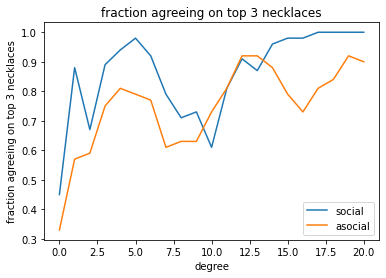

In [46]:
def top_sum(t):
    s = t[0][0] + t[1][0]
    if len(t) > 2 and t[2][0] != None:
        s += t[2][0]
    return s
top_fracs = [top_sum(t) for t in frac_degrees]

pd.DataFrame(top_fracs).to_csv("top_three_frac_agree_social.csv")
top_fracs = pd.read_csv("top_three_frac_agree_social.csv")["0"]
ax = top_fracs.plot(label="social", xlabel="degree", ylabel="fraction agreeing on top 3 necklaces", title="fraction agreeing on top 3 necklaces", legend=True)

asocial_top_fracs = pd.read_csv("top_three_frac_agree_asocial.csv")
asocial_top_fracs = asocial_top_fracs["0"]
asocial_top_fracs.plot(label="asocial", ax=ax)
ax.legend()

In [16]:
max(top_fracs)

0.22

In [17]:
sum(top_fracs)/len(top_fracs)

0.10190476190476193

In [18]:
min(top_fracs)

0.02